数据读取成功!
data1 shape: (170, 5)
data2 shape: (100000, 9)


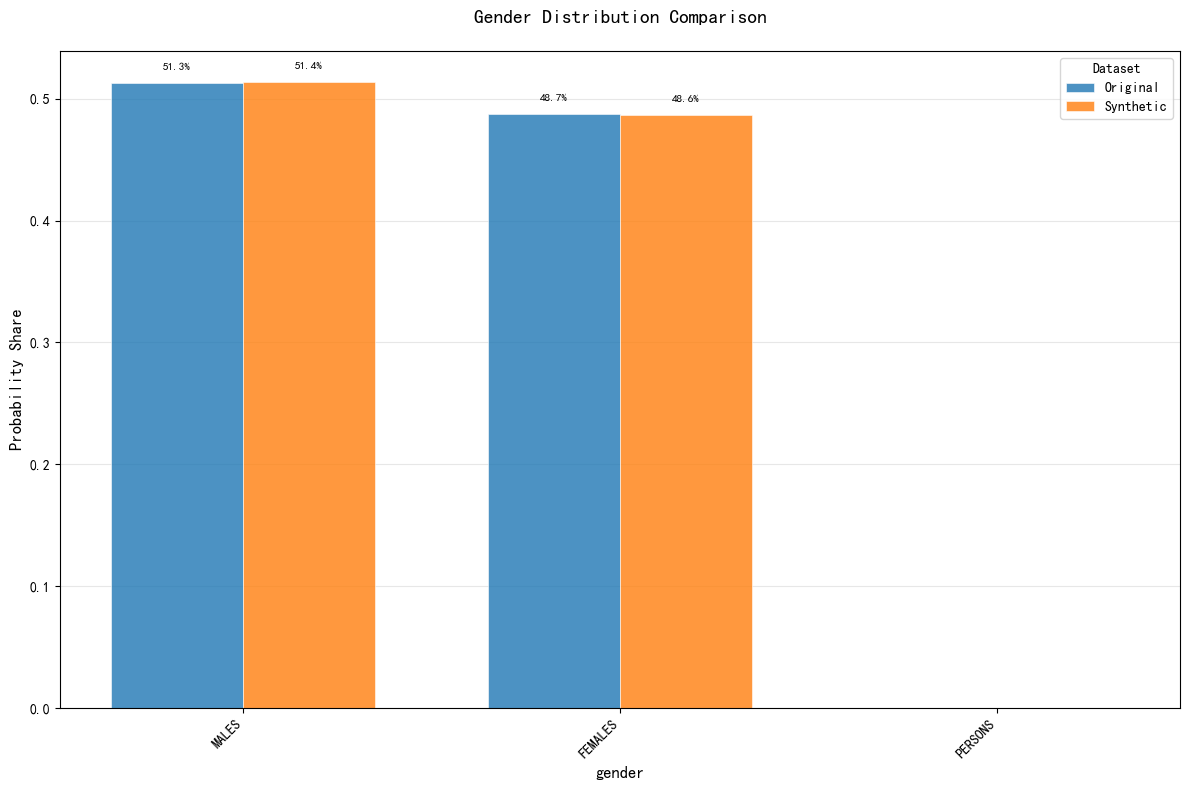

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Optional, List, Tuple, Dict, Any
import warnings
import os
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def create_grouped_bar_chart(data1: pd.DataFrame,
                             data2: pd.DataFrame,
                             column_name1: str,
                             column_name2: str,
                             group1_name: str = "New",
                             group2_name: str = "Old",
                             chart_title: Optional[str] = None,
                             subtitle: Optional[str] = None,
                             factor_level: Optional[List[str]] = None,
                             show_percentage: bool = True,
                             color_palette: List[str] = ["#1f77b4", "#ff7f0e"],
                             figsize: Tuple[int, int] = (12, 8),
                             save_path: Optional[str] = None,
                             save_format: str = 'png',
                             save_dpi: int = 300,
                             save_bbox_inches: str = 'tight') -> Tuple[plt.Figure, pd.DataFrame]:
    """
    创建分组柱状图的主函数 - 支持不同数据集使用不同列名

    Parameters:
    -----------
    data1, data2 : pd.DataFrame
        要比较的两个数据集
    column_name1, column_name2 : str
        要比较的列名
    group1_name, group2_name : str
        组名标签
    chart_title : str, optional
        图表标题
    subtitle : str, optional
        副标题
    factor_level : list, optional
        类别顺序
    show_percentage : bool
        是否显示百分比标签
    color_palette : list
        颜色配色方案
    figsize : tuple
        图表大小
    save_path : str, optional
        保存路径（不包含扩展名）
    save_format : str
        保存格式 ('png', 'pdf', 'svg', 'jpg', 'eps')
    save_dpi : int
        保存分辨率
    save_bbox_inches : str
        边界框设置

    Returns:
    --------
    fig : matplotlib.figure.Figure
        图表对象
    summary_data : pd.DataFrame
        汇总数据
    """

    # 检查列是否存在
    if column_name1 not in data1.columns:
        raise ValueError(f"Column {column_name1} not found in data1")
    if column_name2 not in data2.columns:
        raise ValueError(f"Column {column_name2} not found in data2")

    # 提取指定列的数据并移除NA值
    col1 = data1[column_name1].dropna()
    col2 = data2[column_name2].dropna()

    # 确保两个数据集都有number_of_jobs列，如果没有则创建
    if 'number_of_jobs' not in data1.columns:
        data1 = data1.copy()
        data1['number_of_jobs'] = 1
    if 'number_of_jobs' not in data2.columns:
        data2 = data2.copy()
        data2['number_of_jobs'] = 1

    # 创建合并数据框
    df1_subset = data1[[column_name1, 'number_of_jobs']].dropna()
    df2_subset = data2[[column_name2, 'number_of_jobs']].dropna()

    # 重命名列以便合并
    df1_subset = df1_subset.rename(columns={column_name1: 'category'})
    df2_subset = df2_subset.rename(columns={column_name2: 'category'})

    # 添加分组标识
    df1_subset['group'] = group1_name
    df2_subset['group'] = group2_name

    # 合并数据
    combined_data = pd.concat([df1_subset, df2_subset], ignore_index=True)

    # 计算频数和比例
    summary_data = combined_data.groupby(['group', 'category'])['number_of_jobs'].sum().reset_index()
    summary_data.columns = ['group', 'category', 'count']

    # 计算总数和比例
    group_totals = summary_data.groupby('group')['count'].sum().reset_index()
    group_totals.columns = ['group', 'total']
    

    summary_data = summary_data.merge(group_totals, on='group')
    summary_data['proportion'] = summary_data['count'] / summary_data['total']
    summary_data['percentage'] = summary_data['proportion'] * 100

    # 确保所有类别在两个组中都存在（填充0）
    all_categories = summary_data['category'].unique()
    all_groups = summary_data['group'].unique()

    # 创建完整的组合
    complete_grid = pd.MultiIndex.from_product([all_groups, all_categories],
                                               names=['group', 'category']).to_frame(index=False)

    summary_data = complete_grid.merge(summary_data, on=['group', 'category'], how='left')
    summary_data = summary_data.fillna(0)

    # 设置类别顺序
    if factor_level is not None:
        # 只保留factor_level中存在的类别
        summary_data = summary_data[summary_data['category'].isin(factor_level)]
        summary_data['category'] = pd.Categorical(summary_data['category'],
                                                  categories=factor_level,
                                                  ordered=True)
    else:
        # 按第一个组的比例排序
        first_group_order = summary_data[summary_data['group'] == group1_name].sort_values(
            'proportion', ascending=False)['category'].values
        summary_data['category'] = pd.Categorical(summary_data['category'],
                                                  categories=first_group_order,
                                                  ordered=True)

    summary_data = summary_data.sort_values(['category', 'group'])

    # 设置默认标题
    if chart_title is None:
        chart_title = f"{column_name2} Distribution Comparison"

    # 创建图表
    fig, ax = plt.subplots(figsize=figsize)

    # 获取类别和组
    categories = summary_data['category'].cat.categories
    groups = summary_data['group'].unique()

    # 设置柱状图位置
    x = np.arange(len(categories))
    width = 0.35

    # 为每个组创建柱状图
    for i, group in enumerate(groups):
        group_data = summary_data[summary_data['group'] == group].set_index('category')
        group_data = group_data.reindex(categories, fill_value=0)

        bars = ax.bar(x + i*width - width/2, group_data['proportion'],
                      width, label=group, color=color_palette[i],
                      alpha=0.8, edgecolor='white', linewidth=0.5)

        # 添加百分比标签
        if show_percentage:
            for j, bar in enumerate(bars):
                height = bar.get_height()
                if height > 0.005:  # 只显示大于0.5%的标签
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{group_data.iloc[j]["percentage"]:.1f}%',
                            ha='center', va='bottom', fontsize=8)

    # 设置图表样式
    ax.set_xlabel(column_name1, fontsize=12)
    ax.set_ylabel('Probability Share' if show_percentage else 'Proportion', fontsize=12)
    ax.set_title(chart_title, fontsize=14, fontweight='bold', pad=20)
    if subtitle:
        ax.text(0.5, 1.02, subtitle, transform=ax.transAxes,
                ha='center', fontsize=12)

    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend(title='Dataset', loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)

    # 调整布局
    plt.tight_layout()

    
if __name__ == "__main__":

    # AGE and GENDER compare
    data1 = pd.read_csv(r"C:\Users\HOU HENGJIN\Desktop\VIS\Age group_gender.csv")
    data2 = pd.read_csv(r"C:\Users\HOU HENGJIN\Desktop\VIS\BN1.0_samples_100000.csv")
    data2['number_of_jobs'] = 1

    print("数据读取成功!")
    print(f"data1 shape: {data1.shape}")
    print(f"data2 shape: {data2.shape}")

# 1. 比较性别分布
create_grouped_bar_chart(
    data1=data1,
    data2=data2,
    column_name1="gender",
    column_name2="Gender",
    group1_name="Original",
    group2_name="Synthetic",
    factor_level=gender_level,
    chart_title="Gender Distribution Comparison"
)

plt.show()

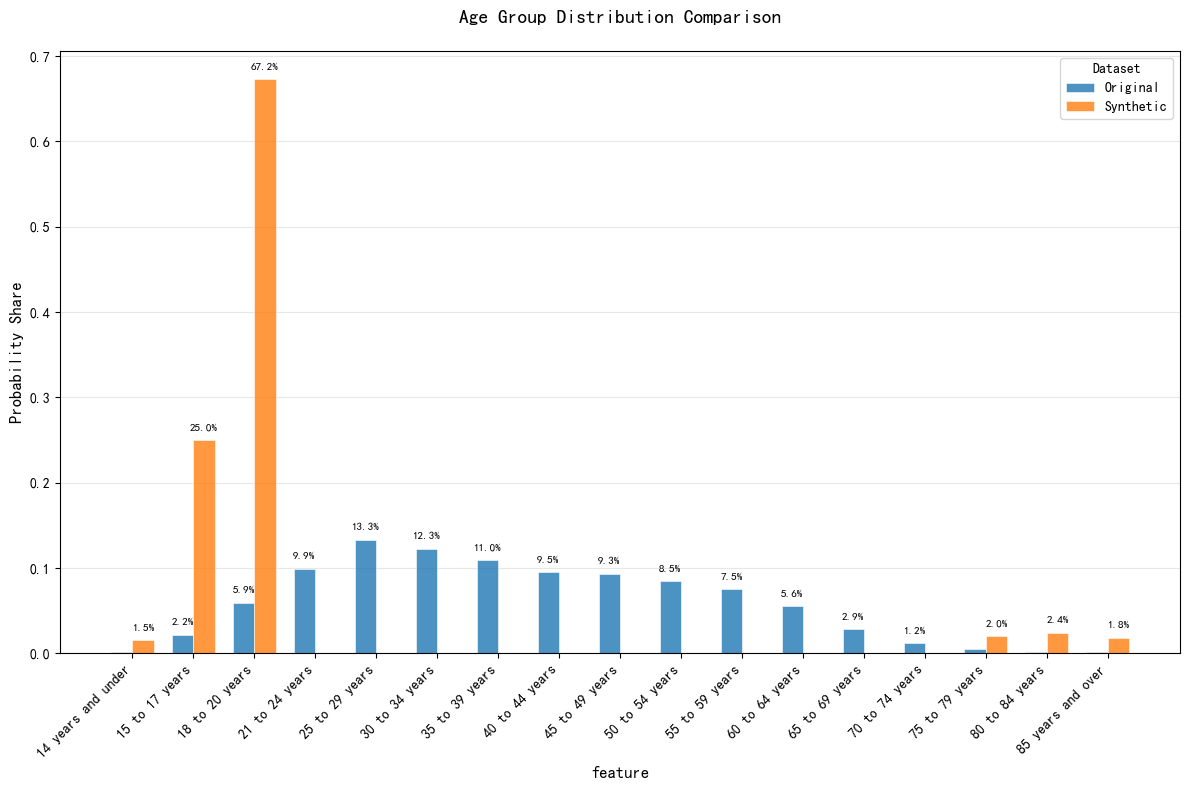

In [53]:
# 2. 比较年龄分布
create_grouped_bar_chart(
            data1=data1,
            data2=data2,
            column_name1="feature",
            column_name2="AgeGroup",
            group1_name="Original",
            group2_name="Synthetic",
            factor_level=data1['feature'].unique() if 'feature' in data1.columns else None,
            chart_title="Age Group Distribution Comparison",
            save_path=f"{output_dir}/age_distribution_comparison"
        )

plt.show()

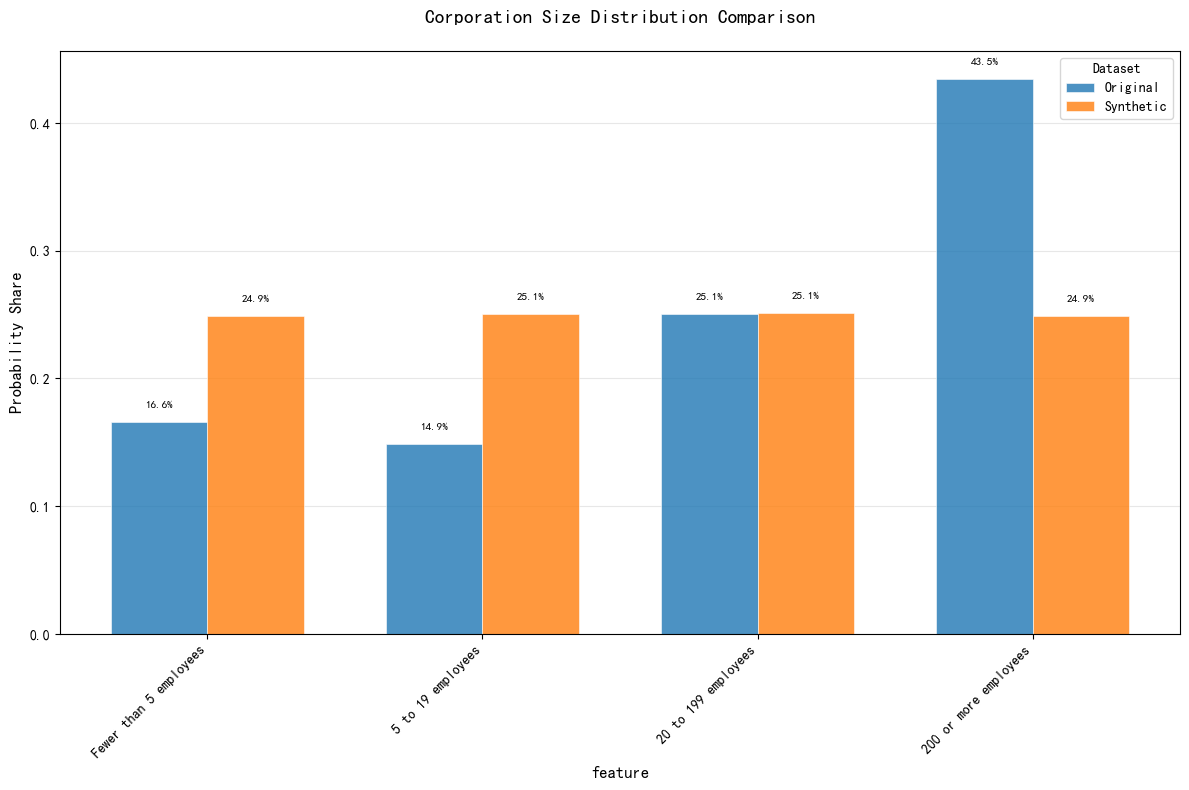

In [78]:
# 3. 比较公司规模分布
try:
        # 读取公司规模数据
    try:
        data3 = pd.read_excel(r"C:\Users\HOU HENGJIN\Desktop\VIS\Business_size_gender.xlsx")
    except:
        print("未找到Business_size_gender.xlsx，数据引用错误，使用示例数据")
        data3 = pd.DataFrame({
                'feature': ['Fewer than 5 employees', '5 to 19 employees',
                            '20 to 199 employees', '200 or more employees'] * 50,
                'number_of_jobs': np.ones(200)
        })

        # 数据清理
    if 'CorpSize' in data2.columns:
        data2['CorpSize'] = data2['CorpSize'].replace({
                '5–19 employees': '5 to 19 employees',
                '20–199 employees': '20 to 199 employees'
        })

    CorpSize_levels = ["Fewer than 5 employees", "5 to 19 employees",
                           "20 to 199 employees", "200 or more employees"]
    
    create_grouped_bar_chart(
        data1=data3,
        data2=data2,
        column_name1="feature",
        column_name2="CorpSize",
        group1_name="Original",
        group2_name="Synthetic",
        factor_level=CorpSize_levels,
        chart_title="Corporation Size Distribution Comparison"
    )

    plt.show()

except Exception as e:
    print(f"生成公司规模分布图时出错: {e}")

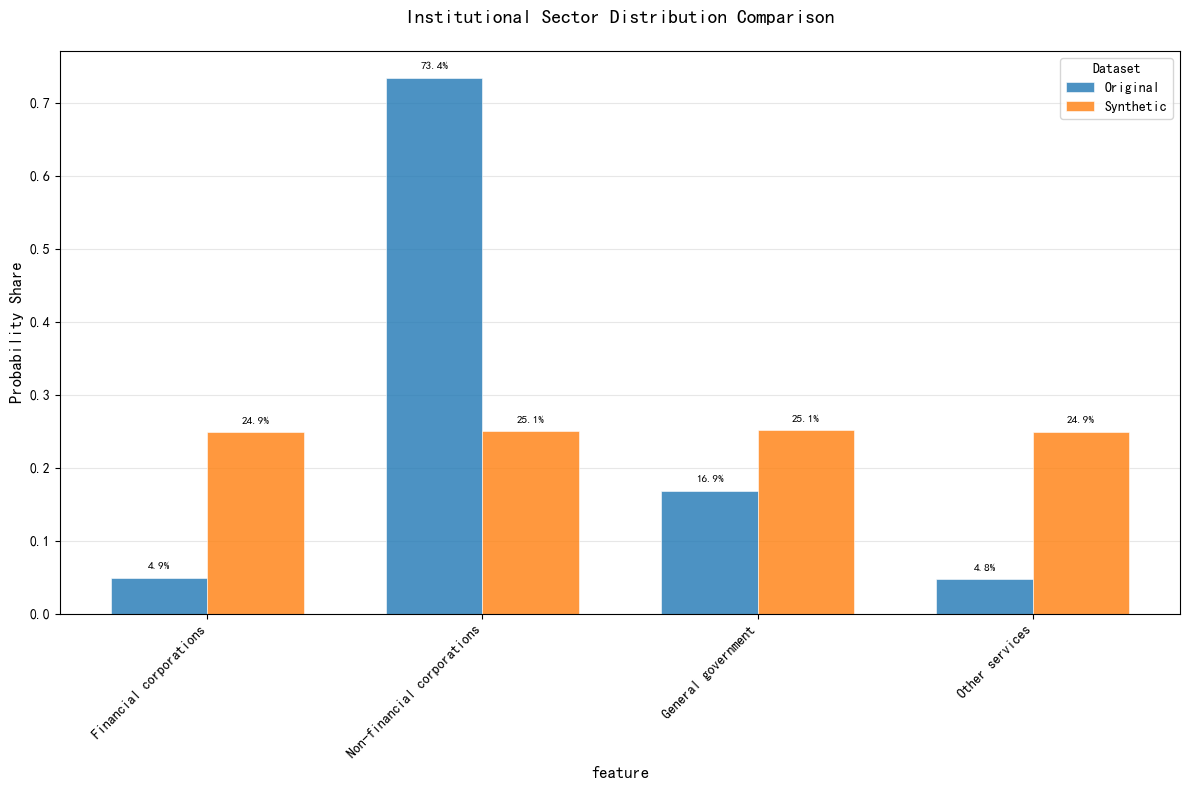

In [81]:
    # 4. Sector分布比较
    try:
        try:
            data4 = pd.read_excel(r"C:\Users\HOU HENGJIN\Desktop\VIS\Institutional sector_gender.xlsx")
        except:
            print("未找到Institutional sector_gender.xlsx，使用示例数据")
            data4 = pd.DataFrame({
                'feature': ['Financial corporations', 'Non-financial corporations',
                            'General government', 'Other services'] * 50,
                'number_of_jobs': np.ones(200)
            })

        create_grouped_bar_chart(
            data1=data4,
            data2=data2,
            column_name1="feature",
            column_name2="Sector",
            group1_name="Original",
            group2_name="Synthetic",
            factor_level=["Financial corporations", "Non-financial corporations",
                          "General government", "Other services"],
            chart_title="Institutional Sector Distribution Comparison",
            save_path=f"{output_dir}/sector_distribution_comparison"
        )
        plt.show()
        
    except Exception as e:
        print(f"Sector比较出错: {e}")

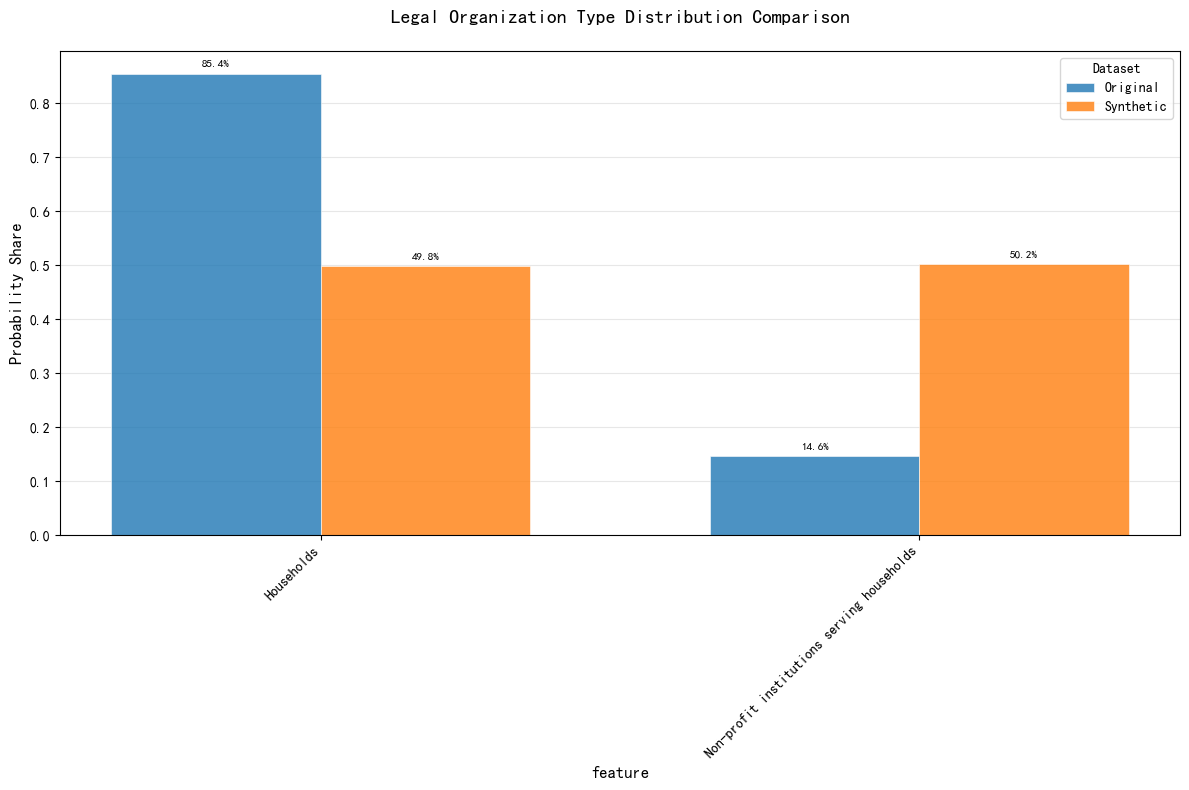

In [84]:
    # 5. LegalOrganization分布比较
    try:
        try:
            data5 = pd.read_excel(r"C:\Users\HOU HENGJIN\Desktop\VIS\Type of legal organisation_gender.xlsx")
        except:
            print("未找到Type of legal organisation_gender.xlsx，使用示例数据")
            data5 = pd.DataFrame({
                'feature': ['Company', 'Partnership', 'Trust', 'Other'] * 50,
                'number_of_jobs': np.ones(200)
            })

        create_grouped_bar_chart(
            data1=data5,
            data2=data2,
            column_name1="feature",
            column_name2="LegalOrganization",
            group1_name="Original",
            group2_name="Synthetic",
            chart_title="Legal Organization Type Distribution Comparison",
            save_path=f"{output_dir}/legal_org_distribution_comparison"
        )
        plt.show()

    except Exception as e:
        print(f"LegalOrganization比较出错: {e}")

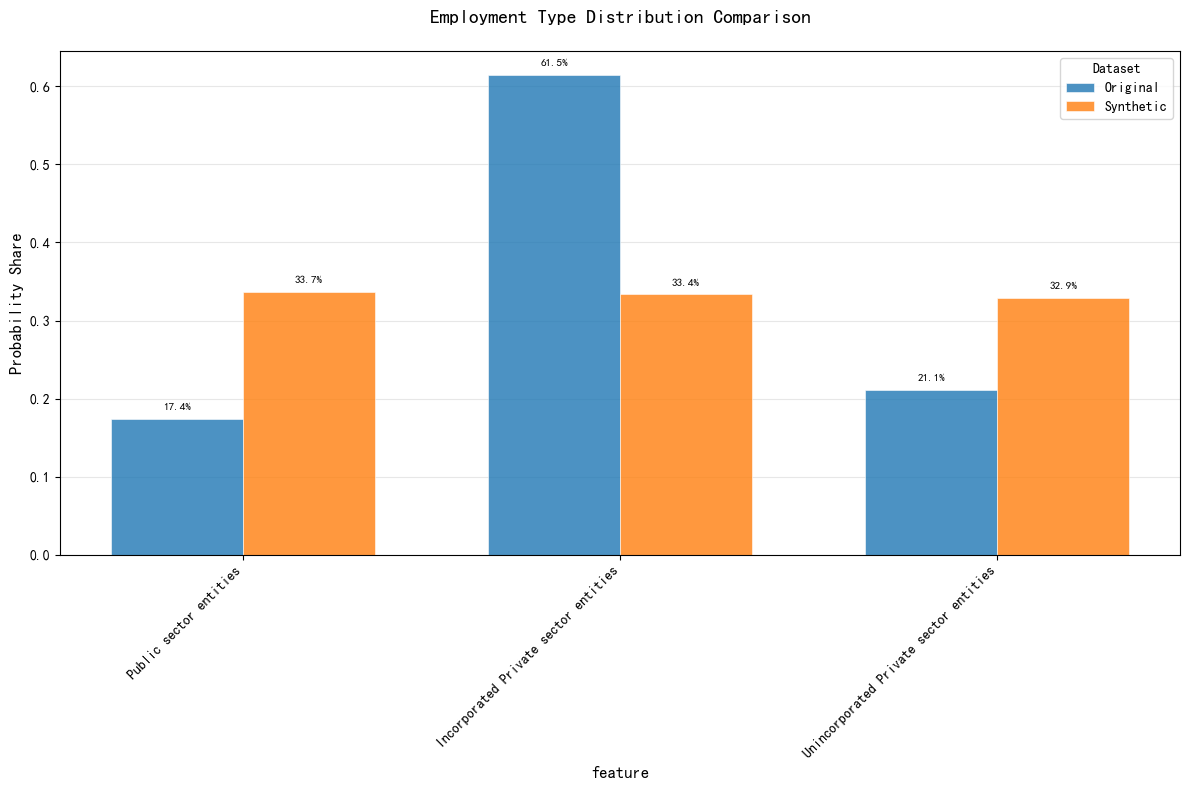

In [85]:
    # 6. EmploymentType分布比较
    try:
        try:
            data6 = pd.read_excel(r"C:\Users\HOU HENGJIN\Desktop\VIS\Employment size_gender.xlsx")
        except:
            print("未找到Employment size_gender.xlsx，使用示例数据")
            data6 = pd.DataFrame({
                'feature': ['Public sector entities', 'Incorporated Private sector entities',
                            'Unincorporated Private sector entities'] * 50,
                'number_of_jobs': np.ones(150)
            })

        create_grouped_bar_chart(
            data1=data6,
            data2=data2,
            column_name1="feature",
            column_name2="EmploymentType",
            group1_name="Original",
            group2_name="Synthetic",
            factor_level=["Public sector entities", "Incorporated Private sector entities",
                          "Unincorporated Private sector entities"],
            chart_title="Employment Type Distribution Comparison",
            save_path=f"{output_dir}/employment_type_distribution_comparison"
        )
        plt.show()

    except Exception as e:
        print(f"EmploymentType比较出错: {e}")

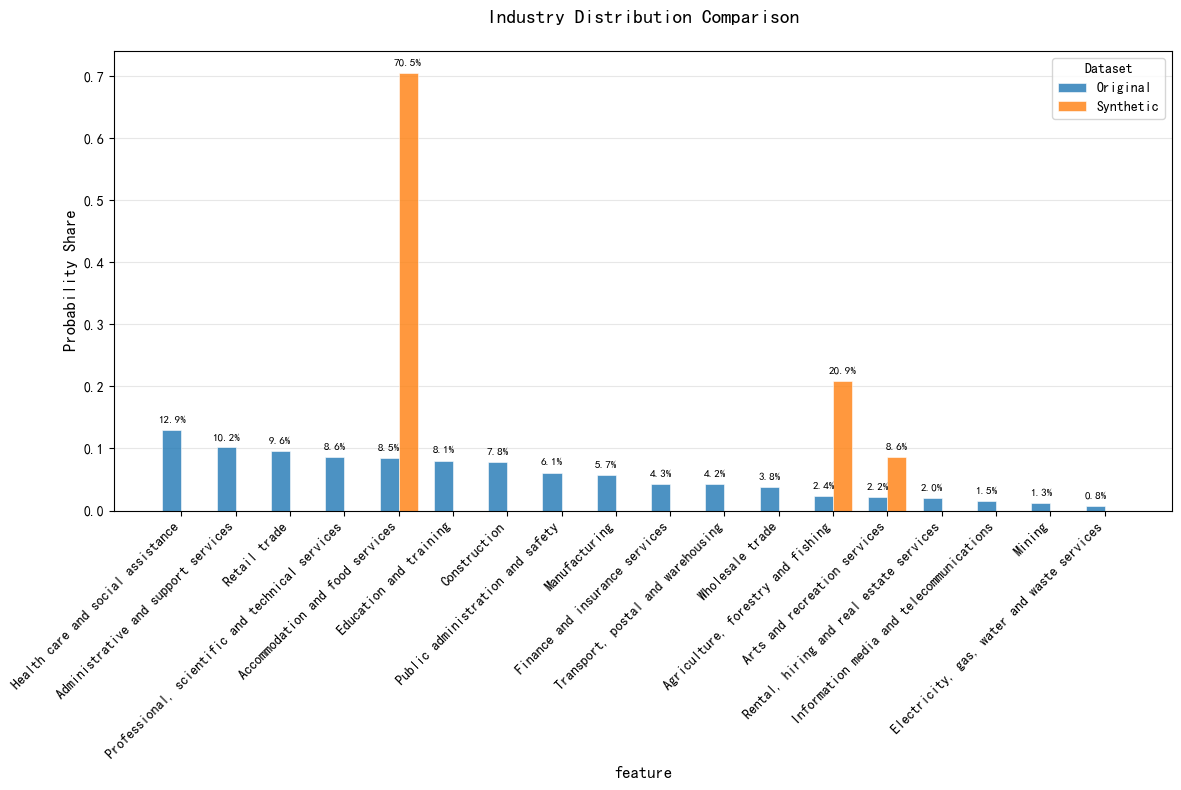

In [87]:
    # 7. Industry分布比较

    try:
        try:
            data7 = pd.read_csv(r"C:\Users\HOU HENGJIN\Desktop\VIS\Industry_gender.csv")
            data7 = data7[data7['feature'] != 'Industry']
        except:
            print("未找到Industry_gender.csv，使用示例数据")
            data7 = pd.DataFrame({
                'feature': ['Agriculture', 'Manufacturing', 'Services', 'Technology', 'Healthcare'] * 50,
                'number_of_jobs': np.ones(250)
            })

        create_grouped_bar_chart(
            data1=data7,
            data2=data2,
            column_name1="feature",
            column_name2="Industry",
            group1_name="Original",
            group2_name="Synthetic",
            chart_title="Industry Distribution Comparison",
            save_path=f"{output_dir}/industry_distribution_comparison"
        )
        plt.show()

    except Exception as e:
        print(f"Industry比较出错: {e}")

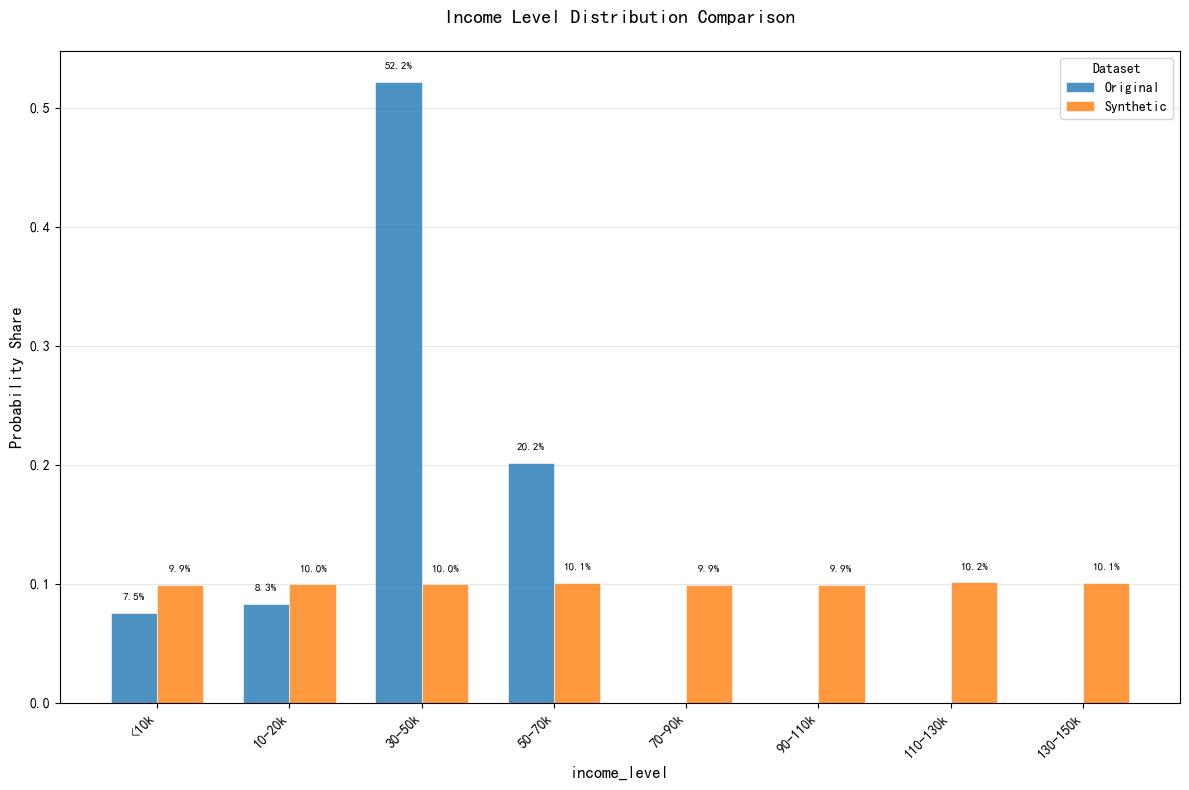

In [98]:
   # 8. Income分布比较
try:
    try:
        data8 = pd.read_excel(r"C:\Users\HOU HENGJIN\Desktop\VIS\Income.xlsx")
    except:
        print("未找到Income.xlsx，使用示例数据")
        data8 = pd.DataFrame({
            'income_level': ['<10k', '10-20k', '30-50k', '50-70k',
                                 '70-90k', '90-110k', '110-130k', '130-150k'] * 50,
            'number_of_jobs': np.ones(400)
        })

    create_grouped_bar_chart(
        data1=data8,
        data2=data2,
        column_name1="income_level",
        column_name2="IncomeLevel",
        group1_name="Original",
        group2_name="Synthetic",
        factor_level=["<10k", "10-20k", "30-50k", "50-70k",
                    "70-90k", "90-110k", "110-130k", "130-150k"],
        chart_title="Income Level Distribution Comparison",
        save_path=f"{output_dir}/income_distribution_comparison"
    )
    plt.show()

except Exception as e:
    print(f"Income比较出错: {e}")